In [1]:
import sacc
import jax
import emcee
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pylab as plt 
import numpy as np
import pyccl as ccl

# our scripts and functions 
from sample import load_data
from cosmology.sampleemcee import emcee_logprior
from cosmology.bandpowers import get_bandpowers_gc, get_bandpowers_gc_wl, get_bandpowers_wl, get_bandpowers_theory
from cosmology.bandpowers import unpack_params_vec, get_params_vec, get_gc_powerspectra, get_gc_wl_powerspectra, get_wl_powerspectra

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


--------------------------------------------------
jax version: 0.4.13
jaxlib version: 0.4.13
numpyro version: 0.12.1
Found 1 JAX devices of type cpu.
We are using TFRT_CPU_0
--------------------------------------------------


In [2]:
ZMAX = 2.0
ELLMIN = 2
NELL = 30
ELLMAX_GC = 300
ELLMAX_WL = 3000
KMIN = 1E-4
KMAX = 50 
ZMIN = 0.0 
BAD_PS = 1E32


EPS = 1E-4
NSAMPLES  = 10

jc.power.USE_EMU = False

In [3]:
def get_test_param():
    cosmo = jc.Cosmology(
        sigma8=0.852,
        Omega_c=0.239,
        Omega_b=0.054,
        h=0.653,
        n_s=0.933,
        w0=-1.0,
        Omega_k=0.0,
        wa=0.0,
    )

    parameter = get_params_vec(
        cosmo,
        [0.074, 0.186, -0.075, -0.108],  # multiplicative
        [-0.008, -0.100, -0.0018, -0.0097], # shifts wl 
        [0.359, -0.011], # [0.359, -0.011], # a_ia, eta
        [1.34, 1.58, 1.60, 1.90, 1.94],  # biases 
        [0.022, -0.0015, 0.02, 0.0097, -0.012] #, # shifts gc
    )
    return parameter


In [4]:
data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl = load_data(fname="cls_DESY1", kmax=0.15, lmin_wl=30, lmax_wl=2000)
parameters = get_test_param()

Maximum ell is 101
Maximum ell is 155
Maximum ell is 206
Maximum ell is 255
Maximum ell is 298


In [5]:
ps_gc, ells_coarse_gc, nbin_gc = get_gc_powerspectra(parameters, jax_nz_gc)
ps_wl, ells_coarse_wl, nbin_wl = get_wl_powerspectra(parameters, jax_nz_wl)
ps_gc_wl, ells_coarse_gc_wl, nbin_gc, nbin_wl = get_gc_wl_powerspectra(parameters, jax_nz_gc, jax_nz_wl)

Not using the emulator
Not using the emulator
Not using the emulator


# CCL

### Weak Lensing

In [6]:
def intrinsic_alignment(redshift, amplitude, eta, redshift_fixed = 0.62):
    return amplitude * ((1 + redshift) / (1 + redshift_fixed)) ** eta

In [24]:
def run_simulator(cosmology):

    try:
        ccl_cosmo = ccl.Cosmology(Omega_c=cosmology.Omega_c.item(), 
                                  Omega_b=cosmology.Omega_b.item(), 
                                  h=cosmology.h.item(), 
                                  sigma8=cosmology.sigma8.item(), 
                                  n_s=cosmology.n_s.item(), 
                                  transfer_function='boltzmann_camb')
    except:
        ccl_cosmo = None 

    return ccl_cosmo

In [25]:
class cosmoclass:

    def __init__(self, parameters, jax_nz_wl, jax_nz_gc):
        self.cosmo, self.multiplicative, self.deltaz_wl, (a_ia_param, eta_param), self.bias, self.deltaz_gc = unpack_params_vec(parameters)

        self.a_ia_param = a_ia_param 
        self.eta_param = eta_param 
        
        self.nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_wl, self.deltaz_wl)]
        self.nz_gc_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=ZMAX) for nzi, dzi in zip(jax_nz_gc, self.deltaz_gc)]
        self.ells_coarse_wl = jnp.geomspace(ELLMIN, ELLMAX_WL, NELL, dtype=jnp.float32)
        self.ells_coarse_gc = jnp.geomspace(ELLMIN, ELLMAX_GC, NELL, dtype=jnp.float32)

        self.nbin_gc = len(self.deltaz_gc)
        self.nbin_wl = len(self.deltaz_wl)

        self.ccl_cosmo = run_simulator(self.cosmo)

def ccl_wl_powerspectra(nz_wl_sys, multiplicative, a_ia_param, eta_param, ccl_cosmo, ells_coarse_wl):
    
    cl_wl_ccl = []
    nbin_wl = len(multiplicative)
    
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
    
            z_i = nz_wl_sys[i].params[0].params[0]
            z_j = nz_wl_sys[j].params[0].params[0]
    
            nz_i = nz_wl_sys[i].pz_fn(z_i)
            nz_j = nz_wl_sys[j].pz_fn(z_j)

            m_i = multiplicative[i].item()
            m_j = multiplicative[j].item()
            
            A_IA_i = intrinsic_alignment(z_i, a_ia_param, eta_param)
            A_IA_j = intrinsic_alignment(z_j, a_ia_param, eta_param)

            if ccl_cosmo is not None:
                t1 = ccl.WeakLensingTracer(ccl_cosmo, dndz=(z_i, nz_i), has_shear=True, ia_bias=(z_i, A_IA_i))
                t2 = ccl.WeakLensingTracer(ccl_cosmo, dndz=(z_j, nz_j), has_shear=True, ia_bias=(z_j, A_IA_j))
                cl = ccl.angular_cl(ccl_cosmo, t1, t2, ells_coarse_wl)  * (1.0 + m_i) * (1.0 + m_j)
            else:
                cl = jnp.ones_like(ells_coarse_wl) * BAD_PS
            
            cl_wl_ccl.append(cl)
    return cl_wl_ccl

def ccl_gc_powerspectra(nz_gc_sys, bias, ccl_cosmo, ells_coarse_gc):

    cl_gc_ccl = []
    nbin_gc = len(bias)
    for i in range(nbin_gc):
    
        redshift = nz_gc_sys[i].params[0].params[0]
        z_dist = nz_gc_sys[i].pz_fn(redshift)
        
        bias_i = bias[i].item() * np.ones_like(redshift)
        tracer = ccl.tracers.NumberCountsTracer(ccl_cosmo, dndz=(redshift, z_dist), bias = (redshift, bias_i), has_rsd=False)
        if ccl_cosmo is not None:
            cl = ccl.angular_cl(ccl_cosmo, tracer, tracer, ells_coarse_gc)
        else:
            cl = jnp.ones_like(ells_coarse_gc) * BAD_PS
        
        cl_gc_ccl.append(cl)
    return cl_gc_ccl

def ccl_gc_wl_powerspectra(nz_wl_sys, nz_gc_sys, multiplicative, a_ia_param, eta_param, bias, ccl_cosmo, ells_coarse_gc):

    nbin_wl = len(multiplicative)
    nbin_gc = len(bias)
    
    cl_gc_wl_ccl = []
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            # gc 
            z_i = nz_gc_sys[i].params[0].params[0]
            nz_i = nz_gc_sys[i].pz_fn(z_i)
            b_i = bias[i].item() *np.ones_like(z_i)
            
        
            # wl 
            z_j = nz_wl_sys[j].params[0].params[0]
            nz_j = nz_wl_sys[j].pz_fn(z_j)
            m_j = multiplicative[j].item()
            A_IA_j = intrinsic_alignment(z_j, a_ia_param, eta_param)
            
            if ccl_cosmo is not None:
                t_i = ccl.tracers.NumberCountsTracer(ccl_cosmo, dndz=(z_i, nz_i), bias = (z_i, b_i), has_rsd=False)
                t_j = ccl.WeakLensingTracer(ccl_cosmo, dndz=(z_j, nz_j), has_shear=True, ia_bias=(z_j, A_IA_j))
                cl = ccl.angular_cl(ccl_cosmo, t_i, t_j, ells_coarse_gc)  * (1.0 + m_j)
            else:
                cl = jnp.ones_like(ells_coarse_gc) * BAD_PS
                
            cl_gc_wl_ccl.append(cl)
    return cl_gc_wl_ccl

In [26]:
%%time
cosmolib = cosmoclass(parameters, jax_nz_wl, jax_nz_gc)

CPU times: user 6.91 ms, sys: 0 ns, total: 6.91 ms
Wall time: 6.66 ms


In [27]:
ccl_ps_wl = ccl_wl_powerspectra(cosmolib.nz_wl_sys, 
                                cosmolib.multiplicative, 
                                cosmolib.a_ia_param, 
                                cosmolib.eta_param, 
                                cosmolib.ccl_cosmo, 
                                cosmolib.ells_coarse_wl)

ccl_ps_gc = ccl_gc_powerspectra(cosmolib.nz_gc_sys, 
                                cosmolib.bias, 
                                cosmolib.ccl_cosmo, 
                                cosmolib.ells_coarse_gc)

ccl_ps_gc_wl = ccl_gc_wl_powerspectra(cosmolib.nz_wl_sys, 
                                      cosmolib.nz_gc_sys, 
                                      cosmolib.multiplicative, 
                                      cosmolib.a_ia_param, 
                                      cosmolib.eta_param, 
                                      cosmolib.bias, 
                                      cosmolib.ccl_cosmo, 
                                      cosmolib.ells_coarse_gc)

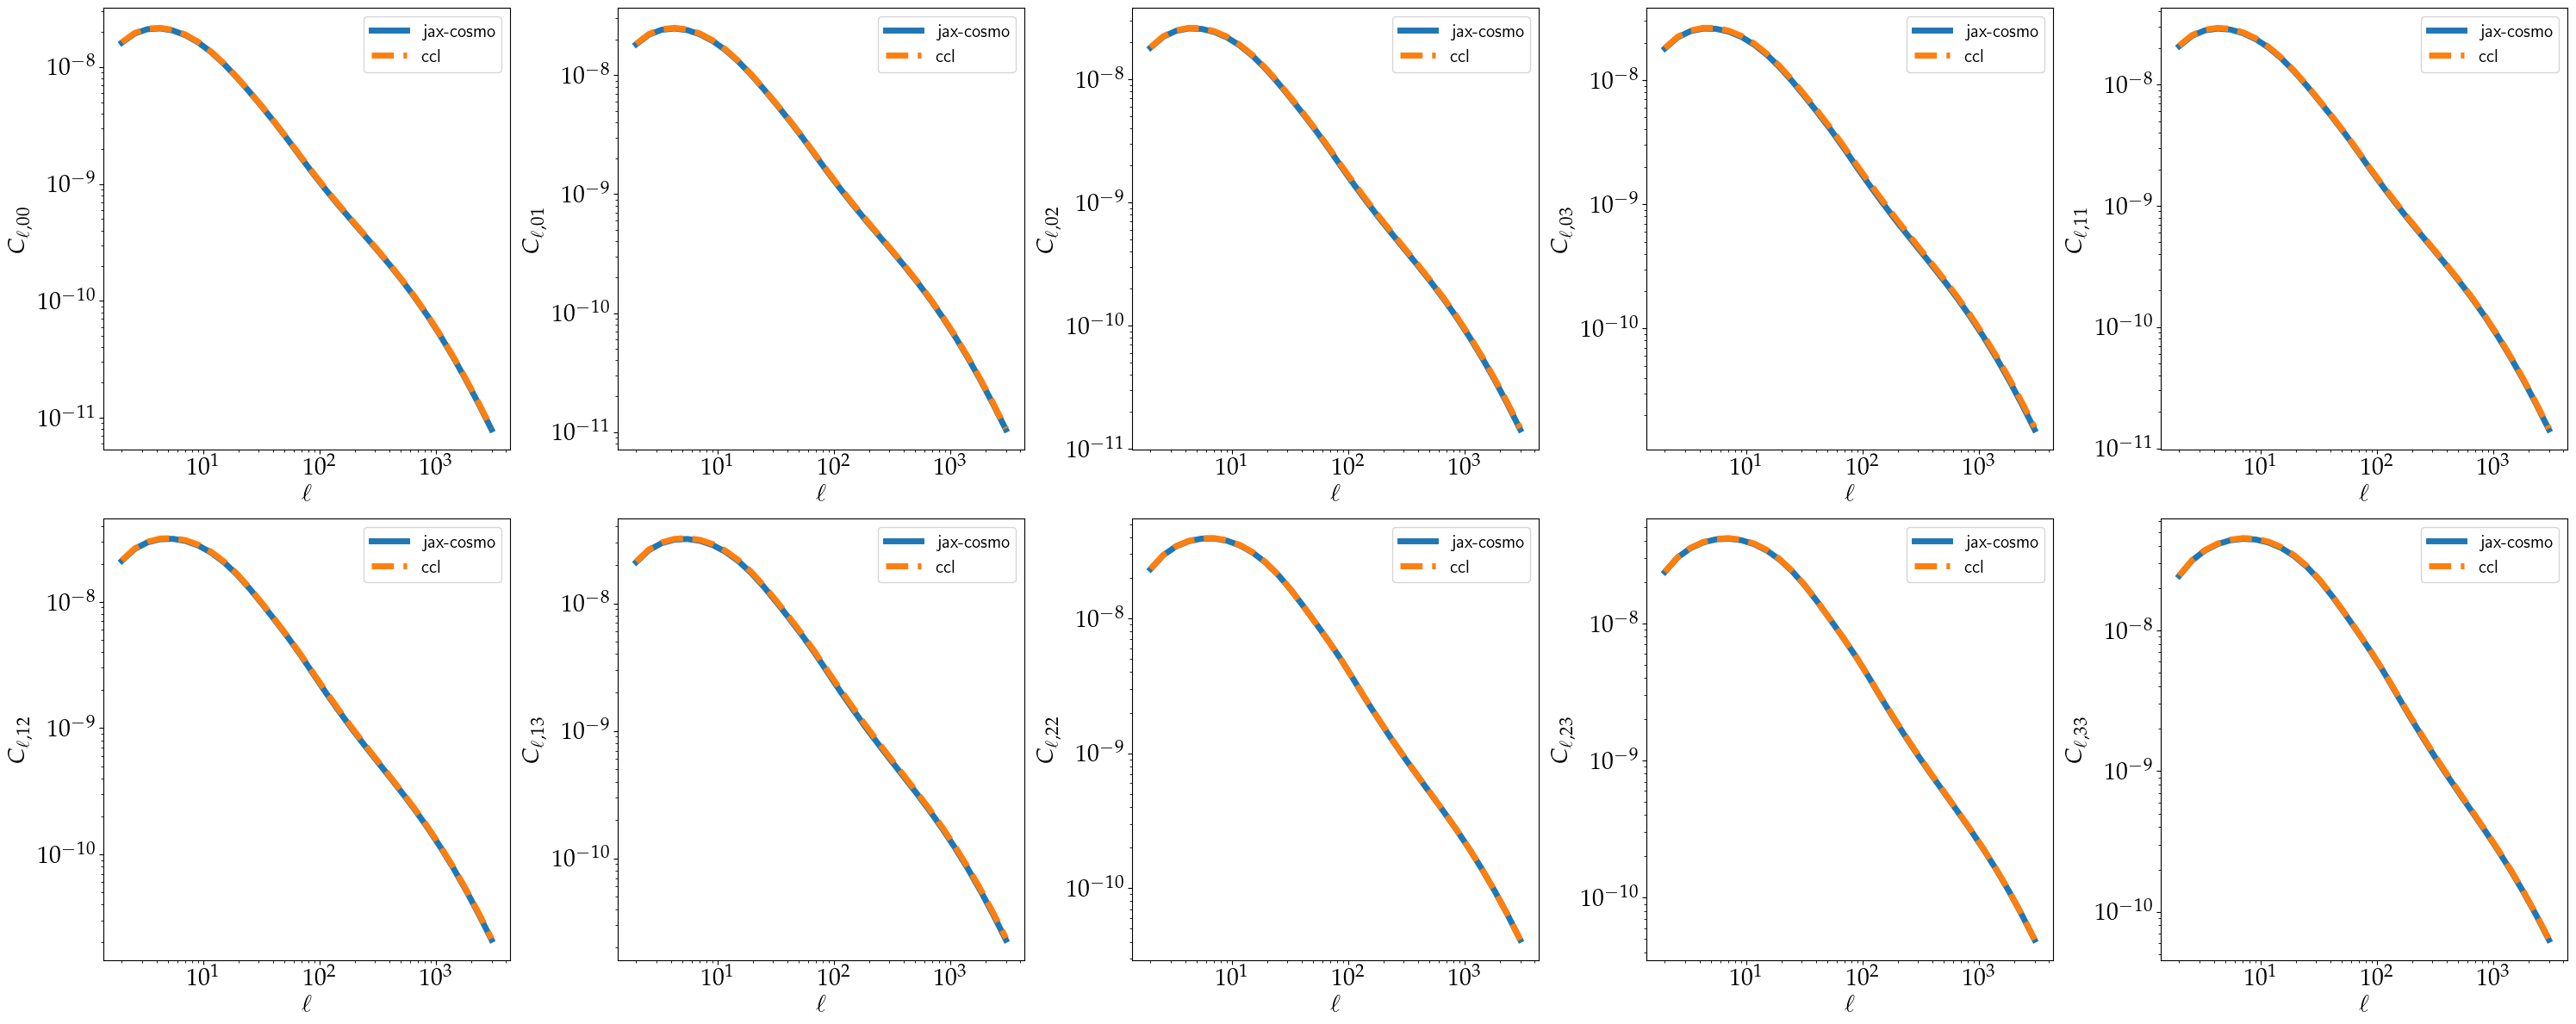

In [28]:
plt.figure(figsize = (30, 12))
counter = 0 
for i in range(4):
    for j in range(i, 4):
        plt.subplot(2, 5, counter+1)
        plt.loglog(ells_coarse_wl, ps_wl[counter], label = 'jax-cosmo', lw = 5)
        plt.loglog(ells_coarse_wl, ccl_ps_wl[counter], label = 'ccl', linestyle = '--', lw = 5)
        plt.ylabel('$C_{\ell,' + f'{i}{j}' + '}$', fontsize = fontSize)
        plt.xlabel(r'$\ell$', fontsize = fontSize)
        plt.tick_params(axis='x', labelsize=fontSize)
        plt.tick_params(axis='y', labelsize=fontSize)
        plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
        counter += 1
plt.tight_layout()
plt.show()

### Galaxy Clustering

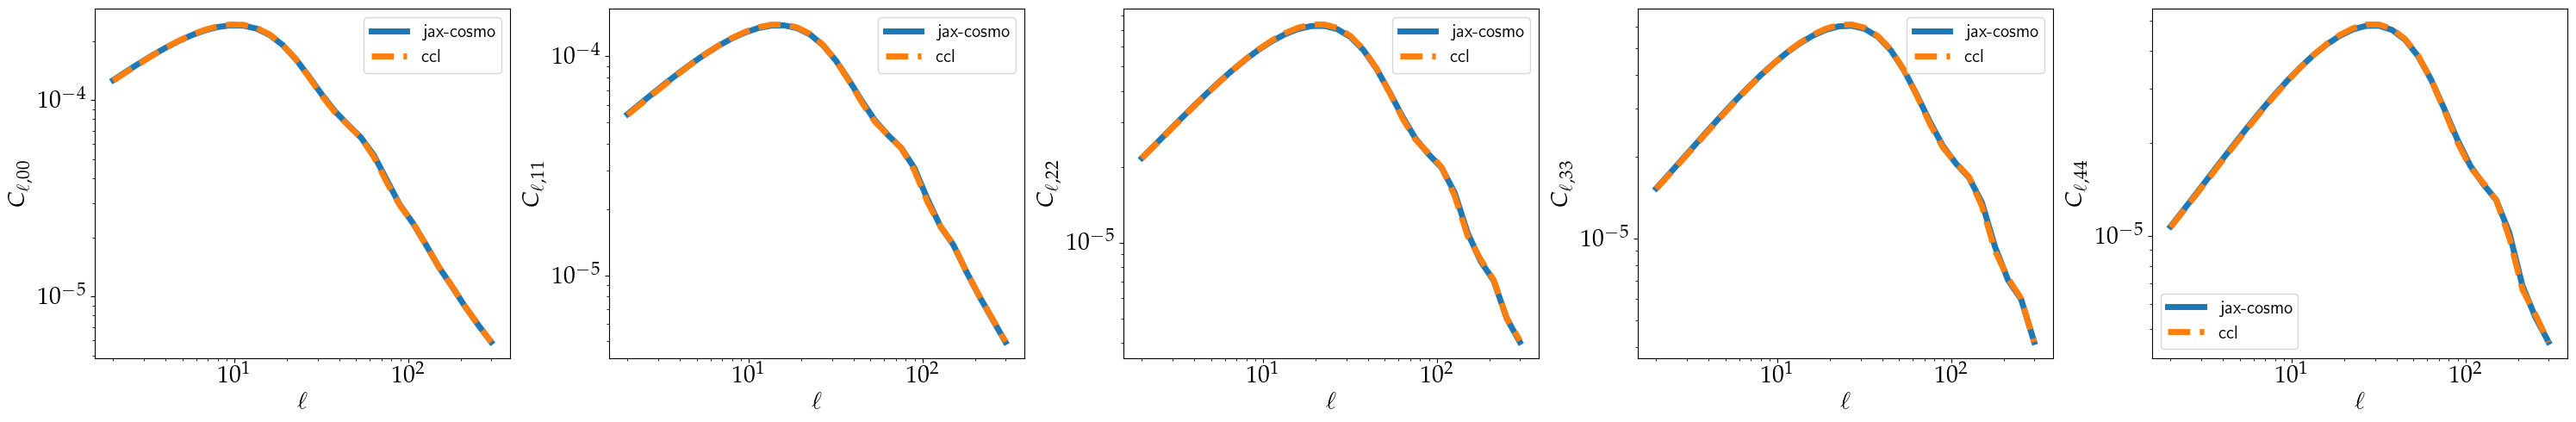

In [29]:
plt.figure(figsize = (30, 5))
for i in range(nbin_gc):
    plt.subplot(1, nbin_gc, i+1)
    plt.loglog(ells_coarse_gc, ps_gc[i], label = 'jax-cosmo', lw = 5)
    plt.loglog(ells_coarse_gc, ccl_ps_gc[i], label = 'ccl', linestyle = '--', lw = 5)
    plt.ylabel('$C_{\ell,' + f'{i}{i}' + '}$', fontsize = fontSize)
    plt.xlabel(r'$\ell$', fontsize = fontSize)
    plt.tick_params(axis='x', labelsize=fontSize)
    plt.tick_params(axis='y', labelsize=fontSize)
    plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.tight_layout()
plt.show()

### Weak Lensing and Galaxy Clustering

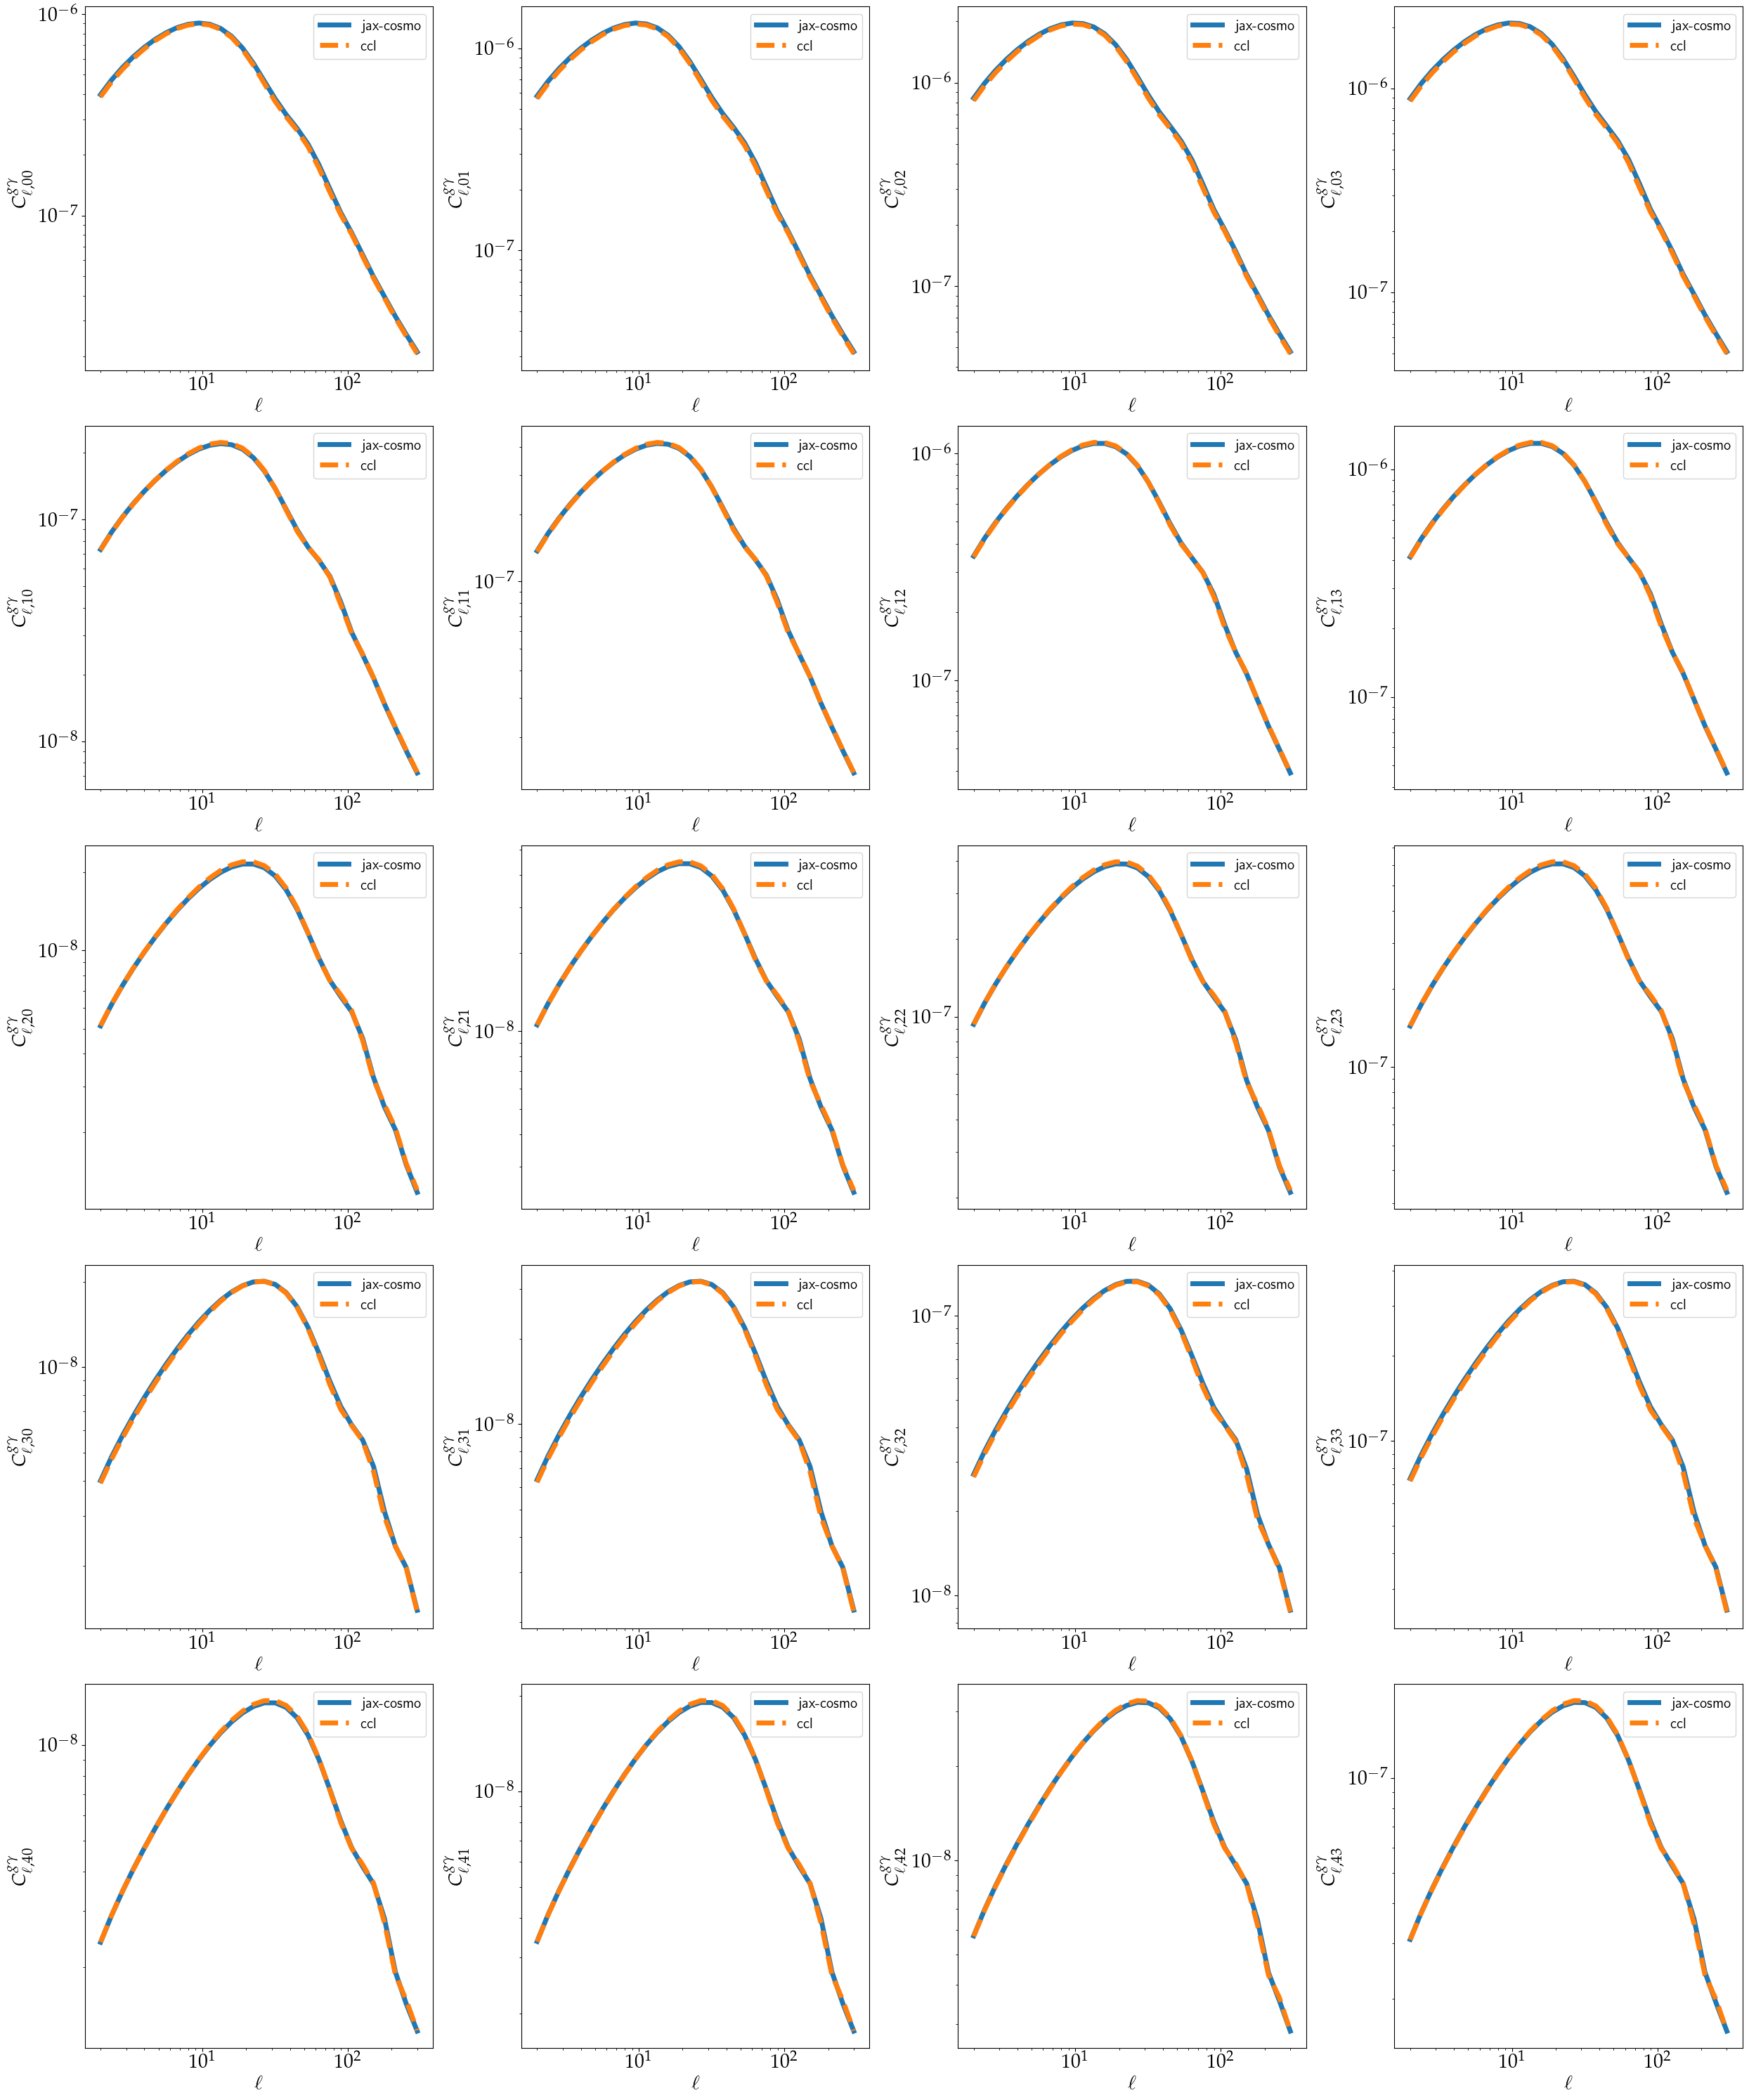

In [30]:
plt.figure(figsize = (25, 30))
counter = 0 
for i in range(nbin_gc):
    for j in range(nbin_wl):
        plt.subplot(nbin_gc, nbin_wl, counter+1)
        plt.loglog(ells_coarse_gc, ps_gc_wl[counter], label = 'jax-cosmo', lw = 5)
        plt.loglog(ells_coarse_gc, ccl_ps_gc_wl[counter], label = 'ccl', linestyle = '--', lw = 5)
        plt.ylabel('$C^{g\gamma}_{\ell,' + f'{i}{j}' + '}$', fontsize = fontSize)
        plt.xlabel(r'$\ell$', fontsize = fontSize)
        plt.tick_params(axis='x', labelsize=fontSize)
        plt.tick_params(axis='y', labelsize=fontSize)
        plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
        counter += 1
plt.tight_layout()
plt.show()

### Bandpowers Calculation

In [31]:
def ccl_gc_bandpower_calculation(cosmolib, bandwindow_ells, bandwindow_matrix):

    ccl_ps_gc = ccl_gc_powerspectra(cosmolib.nz_gc_sys, 
                                    cosmolib.bias, 
                                    cosmolib.ccl_cosmo, 
                                    cosmolib.ells_coarse_gc)

    gc_bandpowers = get_bandpowers_gc(bandwindow_ells, bandwindow_matrix, cosmolib.ells_coarse_gc, ccl_ps_gc, cosmolib.nbin_gc)
    return gc_bandpowers


def ccl_gc_wl_bandpower_calculation(cosmolib, bandwindow_ells, bandwindow_matrix):
    ccl_ps_gc_wl = ccl_gc_wl_powerspectra(cosmolib.nz_wl_sys, 
                                          cosmolib.nz_gc_sys, 
                                          cosmolib.multiplicative, 
                                          cosmolib.a_ia_param, 
                                          cosmolib.eta_param, 
                                          cosmolib.bias, 
                                          cosmolib.ccl_cosmo, 
                                          cosmolib.ells_coarse_gc)

    gc_wl_bandpowers = get_bandpowers_gc_wl(bandwindow_ells, bandwindow_matrix, 
                                            cosmolib.ells_coarse_gc, ccl_ps_gc_wl, cosmolib.nbin_gc, cosmolib.nbin_wl)
    return gc_wl_bandpowers


def ccl_wl_bandpower_calculation(cosmolib, bandwindow_ells, bandwindow_matrix):
    ccl_ps_wl = ccl_wl_powerspectra(cosmolib.nz_wl_sys, 
                                    cosmolib.multiplicative, 
                                    cosmolib.a_ia_param, 
                                    cosmolib.eta_param, 
                                    cosmolib.ccl_cosmo, 
                                    cosmolib.ells_coarse_wl)

    wl_bandpowers = get_bandpowers_wl(bandwindow_ells, bandwindow_matrix, cosmolib.ells_coarse_wl, ccl_ps_wl, cosmolib.nbin_wl)
    return wl_bandpowers

In [32]:
def ccl_get_bandpowers_theory(cosmolib, bw_gc, bw_gc_wl, bw_wl):

    theory_gc = ccl_gc_bandpower_calculation(cosmolib, bw_gc[0], bw_gc[1])
    theory_gc_wl = ccl_gc_wl_bandpower_calculation(cosmolib, bw_gc_wl[0], bw_gc_wl[1])
    theory_wl = ccl_wl_bandpower_calculation(cosmolib, bw_wl[0], bw_wl[1])

    concat_theory_gc = jnp.concatenate(theory_gc)
    concat_theory_gc_wl = jnp.concatenate(theory_gc_wl)
    concat_theory_wl = jnp.concatenate(theory_wl)
    return jnp.concatenate([concat_theory_gc, concat_theory_gc_wl, concat_theory_wl])

In [33]:
%%time
ccl_theory = ccl_get_bandpowers_theory(cosmolib, bw_gc, bw_gc_wl, bw_wl)

CPU times: user 990 ms, sys: 1.2 ms, total: 991 ms
Wall time: 137 ms


In [34]:
jxc_theory = get_bandpowers_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

Not using the emulator
Not using the emulator
Not using the emulator


In [35]:
ccl_diff = data - ccl_theory 
jxc_diff = data - jxc_theory

In [36]:
ccl_diff @ precision @ ccl_diff

Array(184.66317214, dtype=float64)

In [37]:
jxc_diff @ precision @ jxc_diff

Array(185.81795371, dtype=float64)

## Sampling

In [21]:
def ccl_likelihood(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    cosmolib = cosmoclass(parameters, jax_nz_wl, jax_nz_gc)
    ccl_theory = ccl_get_bandpowers_theory(cosmolib, bw_gc, bw_gc_wl, bw_wl)
    difference = data - ccl_theory 
    chi_square = difference @ precision @ difference 
    if not jnp.isfinite(chi_square):
        chi_square = 1E32
    return -0.5*chi_square

def ccl_logpost(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    loglike = ccl_likelihood(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)
    logprior = emcee_logprior(parameters)
    return loglike + logprior

def ccl_sampling_emcee(data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl): #, cfg):
    parameter = get_test_param()
    nparams = len(parameter)
    pos = parameter + EPS * jax.random.normal(jax.random.PRNGKey(0), (2 * nparams, nparams)) # cfg.emcee.eps
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        ccl_logpost,
        args=(data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl),
    )
    sampler.run_mcmc(pos, NSAMPLES, progress=True) # cfg.emcee.nsamples
    return sampler

In [22]:
# test_sampler = ccl_sampling_emcee(data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

In [38]:
testparam = jnp.array([ 8.24198798e-01,  2.36172015e-01,  1.24267100e-02,  6.29624610e-01,
  9.50066873e-01,  3.19975167e-02,  1.42083898e-01, -4.67777417e-02,
 -8.36598503e-02, -3.00672332e-04, -1.22251129e-01,  4.75198182e-02,
 -1.00751514e-02,  3.82668178e-01, -3.80071170e-02,  1.34807772e+00,
  1.58621959e+00,  1.59965691e+00,  1.92724953e+00,  1.92435691e+00,
 -5.17637753e-03, -2.23784176e-02,  1.55972110e-02, -3.19960865e-03,
 -4.37199299e-02])

In [39]:
testprior = emcee_logprior(testparam)

-1e+32